In [1]:
#Definizione dati Ottimizzatore
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime

init_val={
    'timestamp':15,
    'numChargers' : 12,
    'v2g':False
}

def process_building_load(buildingLoadScaling):
    # Carica il file Excel
    file_path = r'Building_load.xlsx'
    df = pd.read_excel(file_path)

    # Rimuovi spazi bianchi dai valori della colonna "Time"
    df['Time'] = df['Time'].str.strip()

    # Converti la colonna "Time" in formato datetime
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Imposta la colonna "Time" come indice
    df.set_index('Time', inplace=True)

    # Risample i dati ogni 5 minuti calcolando la media
    df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()

    # Converti la colonna "Potenza normalizzata [W]" in un vettore np.array
    potenza_norm_array = df_resampled['Potenza normalizzata [W]'].to_numpy()

    # Calcola il vettore di potenza giornaliero scalando il profilo sul massimo dell'edificio
    potenza_build_array = potenza_norm_array * buildingLoadScaling * 0.7

    return potenza_build_array

def process_pv_production():
    # Leggi il file Excel
    file_path = r'pv_production.xlsx'
    df = pd.read_excel(file_path)

    # Assicurati che le colonne abbiano i nomi corretti
    df.columns = ['Time', 'Value']

    # Converte i dati in un np.array
    original_values = np.array(df['Value'])

    # I tuoi dati originali ogni 15 minuti
    original_time = np.arange(0, 24, 0.25)  # ad esempio da 0 a 24 ore

    # Nuovi intervalli di tempo ogni 5 minuti
    new_time = np.arange(0, 24, init_val['timestamp']/60.)  # da 0 a 24 ore, ogni 5 minuti

    # Usa numpy.interp per interpolare i nuovi valori
    new_values = np.interp(new_time, original_time, original_values)

    return new_values

def array_pun():
    # Carica il file Excel
    file_path=r'hourly_price_PUN.xlsx'
    df = pd.read_excel(file_path)
    
    # Supponiamo che la colonna dei prezzi orari si chiami '€/kWh'
    prezzi_orari = df['€/kWh'].values
    
    # Creiamo un array numpy che ripete ogni valore 12 volte (12 * 5 minuti = 1 ora)
    prezzi_5_minuti = np.repeat(prezzi_orari, 60/init_val['timestamp'])
    
    return prezzi_5_minuti

def time_to_index(hour, minute):
    """Converte un orario (ora, minuto) in un indice del vettore (5 minuti)"""
    return (hour * 60 + minute) // init_val['timestamp']

def create_schedule(connection_times, disconnection_times, num_stations=init_val['numChargers'], intervals_per_day=int((60/init_val['timestamp'])*24)):
    """
    Crea la schedule di connessione/disconnessione per le colonnine.
    
    Parameters:
    - connection_times: lista di liste di tuple (ora, minuto) per la connessione
    - disconnection_times: lista di liste di tuple (ora, minuto) per la disconnessione
    - num_stations: numero di colonnine
    - intervals_per_day: numero di intervalli di 5 minuti in un giorno (288)
    
    Returns:
    - schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    """
    schedules = np.zeros((num_stations, intervals_per_day), dtype=int)
    
    for i in range(num_stations):
        for conn, disc in zip(connection_times[i], disconnection_times[i]):
            conn_index = time_to_index(*conn)
            disc_index = time_to_index(*disc)
            if conn_index < disc_index:
                schedules[i, conn_index:disc_index] = 1
            else:  # gestione di connessione durante la notte (es. dalle 23:00 alle 02:00)
                schedules[i, conn_index:] = 1
                schedules[i, :disc_index] = 1
    
    return schedules

def calculate_residence_times(schedule):
    """
    Calcola il tempo di residenza per ogni veicolo e lo restituisce come una lista di liste.
    
    Parameters:
    - schedule: lista di liste che rappresenta la connessione dei veicoli a una stazione di ricarica (0 o 1)
    
    Returns:
    - residence_times: lista di liste con i tempi di residenza per ogni veicolo in ogni stazione (in minuti)
    """
    residence_times = []
  

    # Itera su ogni stazione di ricarica
    for station_schedule in schedule:
        station_residence_times = []
        block_time = 0

        # Itera su ogni intervallo di tempo nella stazione
        for val in station_schedule:
            if val == 1:
                block_time += init_val['timestamp'] 
            else:
                if block_time > 0:
                    # Aggiunge il tempo totale di residenza del veicolo
                    station_residence_times.append(block_time)
                    block_time = 0

        # Gestisci il caso in cui ci sia un blocco alla fine della lista
        if block_time > 0:
            station_residence_times.append(block_time)

        # Aggiungi i tempi di residenza per la stazione corrente
        residence_times.append(station_residence_times)

    return residence_times

def find_disconnection_times(extended_schedules):
    """
    Trova l'ultimo istante di connessione per ogni colonnina, che è seguito da una disconnessione,
    e restituisce un dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps
    di disconnessione.

    Parameters:
    - extended_schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione

    Returns:
    - disconnection_times: dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps di disconnessione
    """
    num_stations, intervals_per_day = extended_schedules.shape
    disconnection_times = {}

    for i in range(num_stations):
        station_schedule = extended_schedules[i]
        times = []

        # Trova tutti i punti di transizione da 1 a 0
        for t in range(1, intervals_per_day):
            if station_schedule[t-1] == 1 and station_schedule[t] == 0:
                # Aggiungi l'ultimo istante di connessione prima della disconnessione
                times.append(t-1)

        # Se non ci sono disconnessioni, inserisci "0" se non ci sono mai connessioni
        if not times:
            if np.all(station_schedule == 0):
                disconnection_times[i] = [0]
            else:
                disconnection_times[i] = []
        else:
            disconnection_times[i] = times

    return disconnection_times

def find_connection_times(extended_schedules):
    """
    Trova tutti gli istanti di tempo in cui per ogni colonnina si ha la connessione di un veicolo e
    restituisce un dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps
    di disconnessione.
    
    Parameters:
    - extended_schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    
    Returns:
    - connection_times: dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps di connessione
    """
    num_stations, intervals_per_day = extended_schedules.shape
    connection_times = {}
    
    for i in range(num_stations):
        station_schedule = extended_schedules[i]
        times = []
        
        # Trova tutti i punti di transizione da 0 a 1
        for t in range(1, intervals_per_day):
            if station_schedule[t-1] == 0 and station_schedule[t] == 1:
                times.append(t)
        
        # Se non ci sono disconnessioni, inserisci "0" se non ci sono mai connessioni
        if not times:
            if np.all(station_schedule == 0):
                connection_times[i] = [0]
            else:
                connection_times[i] = []
        else:
            connection_times[i] = times

    return connection_times

def calculate_final_soc(initial_soc, PchMax_vehicles, residence_times, battery_capacity, min_soc=0.7, F=0.7):
    """
    Calcola lo stato di carica finale per ogni veicolo e lo restituisce come una lista di liste.
    
    Parameters:
    - initial_soc: lista di liste con lo stato di carica iniziale per ogni veicolo in ogni stazione
    - PchMax_vehicles: lista di liste con la potenza massima con cui può avvenire la ricarica del veicolo, in ogni stazione (kW)
    - residence_times: lista di liste con il tempo di residenza per ogni veicolo in ogni stazione (in minuti)
    - battery_capacity: lista di liste con la capacità della batteria per ogni veicolo in ogni stazione (kWh)
    - min_soc: lo stato di carica minimo da garantire, se il tempo di residenza è sufficiente (default 0.7)
    - F: fattore di rilassamento per permettere all'ottimizzatore di modulare la carica (default 0.8)
    
    Returns:
    - final_soc: lista di liste con lo stato di carica finale per ogni veicolo in ogni stazione
    """
    final_soc = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(initial_soc):
        station_final_soc = []

        # Controlla se la lista dei tempi di residenza è vuota per la stazione
        if not residence_times[i]:
            # Se non ci sono veicoli, assegna 0 come final_soc
            station_final_soc = [0 for _ in station_vehicles]
        else:
            # Itera attraverso i veicoli nella stazione
            for j, soc in enumerate(station_vehicles):
                current_soc = soc

                # Estrai il tempo di residenza, potenza di ricarica e capacità della batteria
                total_residence_time = residence_times[i][j] / 60  # Converti in ore
                charge_increment = (PchMax_vehicles[i][j] * total_residence_time) / battery_capacity[i][j]

                # Calcola lo stato di carica finale
                final_soc_value = min(min_soc, (current_soc + F* charge_increment))

                # Aggiungi il risultato alla lista della stazione
                station_final_soc.append(final_soc_value)

        # Aggiungi i risultati della stazione all'output finale
        final_soc.append(station_final_soc)

    return final_soc

def plot_schedule(schedules, num_stations=12):
    """
    Plot the schedules of multiple charging stations.

    Parameters:
    - schedules: numpy array with connection schedules
    - num_stations: number of charging stations (default: 12)
    """
    fig, axs = plt.subplots(num_stations, 1, figsize=(10, 15), sharex=True)
    time_slots = np.arange(schedules.shape[1])

    for i in range(num_stations):
        axs[i].step(time_slots, schedules[i], where='mid')
        axs[i].set_ylabel(f'Station {i+1}')
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_yticks([0, 1])
        axs[i].grid(True)

    axs[-1].set_xlabel('Time (5-minute intervals)')
    plt.tight_layout()
    plt.show()

def calculate_pchmax_vehicles(nominal_power_values, power_CP_values):
    """
    Calcola la potenza massima di ricarica per ogni veicolo in base alla potenza della colonnina e quella del veicolo.
    
    Parameters:
    - nominal_power_values: lista di liste con la potenza massima di ogni veicolo per stazione (kW)
    - power_CP_values: lista con la potenza massima della colonnina per ogni stazione (kW)
    
    Returns:
    - PchMax_vehicles: lista di liste con la potenza massima di ricarica per ogni veicolo in ogni stazione
    """
    PchMax_vehicles = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(nominal_power_values):
        station_power = power_CP_values[i]
        station_pchmax = []

        # Itera attraverso i veicoli nella stazione
        for vehicle_power in station_vehicles:
            # Calcola il minimo tra la potenza della colonnina e quella del veicolo
            max_power = min(station_power, vehicle_power)
            station_pchmax.append(max_power)

        # Aggiungi i valori della stazione all'output finale
        PchMax_vehicles.append(station_pchmax)

    return PchMax_vehicles

def calculate_pdchmax_vehicles(nominal_power_values, power_CP_values):
    """
    Calcola la potenza massima di ricarica per ogni veicolo in base alla potenza della colonnina e quella del veicolo.
    
    Parameters:
    - nominal_power_values: lista di liste con la potenza massima di ogni veicolo per stazione (kW)
    - power_CP_values: lista con la potenza massima della colonnina per ogni stazione (kW)
    
    Returns:
    - PdchMax_vehicles: lista di liste con la potenza massima di ricarica per ogni veicolo in ogni stazione
    """
    PdchMax_vehicles = []

    # Itera attraverso le stazioni
    for i, station_vehicles in enumerate(nominal_power_values):
        station_power = power_CP_values[i]
        station_pdchmax = []

        # Itera attraverso i veicoli nella stazione
        for vehicle_power in station_vehicles:
            # Calcola il minimo tra la potenza della colonnina e quella del veicolo
            max_power = min(station_power, vehicle_power)
            station_pdchmax.append(max_power)

        # Aggiungi i valori della stazione all'output finale
        PdchMax_vehicles.append(station_pdchmax)

    return PdchMax_vehicles

def timestamp_to_hour(timestamp):
    #Inserendo il numero di timestamp(timestamp) restituisce una lista con ore e minuti riferiti a quel timestamp
    tempo=timestamp*init_val['timestamp']/60
    ore = int(tempo)
    minuti = round((tempo-ore)*60)
    return [ore, minuti]

def sleep_con_interruzione(durata):
    inizio = tm.time()
    while tm.time() - inizio < durata:
        if keyboard.is_pressed('esc'):  # Verifica se è stato premuto 'Esc'
            print("Interrotto dal tasto Esc!")
            return
        tm.sleep(0.5)  # Attende brevi intervalli invece di bloccare completamente

def read_schedule():
    df = pd.read_csv('schedule.csv', header=0)
    




############ DEFINIZIONE DEI DATI DI INPUT ################

############# PROFILI DI CONSUMO O PRODUZIONE ##################

buildingLoadScaling= 378*0.95 #kW default 378*0.95
timeStamp=1/(60/init_val['timestamp']) #andiamo a creare dei timestamp della durata di 5 minuti, quindi 1/12 dell'ora
power_consumption=process_building_load(buildingLoadScaling)   #importo il profilo di carico giornaliero dell'edificio [kW]
power_pv=process_pv_production()   #importo il profilo di produzione giornaliero da pv [kW]

############# PROFILI DI COSTI/TARIFFE ######################

# dichiaro il vettore dei prezzi di acquisto dell'energia per ogni time step
spread=0.06   #spread sul prezzo dell'energia in €/kWh (maggiorazione del prezzo di acquisto rispetto a quello di vendita)
costi_in=(array_pun()+spread)*timeStamp #€ per l'energia data da 1kW per la durata del timestamp

# dichiaro il vettorie dei prezzi di vendita dell'energia per ogni time step
costi_out=array_pun()*timeStamp

#########################################################################
# per sviluppo futuro i profili devono leggere input all'istante di esecuzione quindi
# il primo elemento dei vettori devono essere sostituiti dalla "lettura" di meter o simili

#dichiaro poi il vettore dei prezzi di acquisto dell'energia da parte degli utenti del parcheggio, scelti dal gestore
fee_AC=0.3 #€/kWh
fee_DC=0.5 #€/kWh

cost_AC=fee_AC*timeStamp  #costo in € per l'energia data da 1 kW per 5 minuti
cost_DC=fee_DC*timeStamp  #costo in € per l'energia data da 1 kW per 5 minuti

user_cost=np.array([cost_AC]*10+[cost_DC]*2)  #creao un array che definisce i costi per la ricarica in ogni colonnina (12 elementi)

################## DATI DI INPUT SUGLI UTENTI  ########################

#si deve definire anche un profilo temporale per ogni veicolo elettrico che ci dia indicazioni sul tempo di residenza degli EV
#le prime 6 righe rappresentano le schedule dei lavoratori fissi (colonnine AC)
#poi le 3 successive rappresentano i trasfertisti (colonnine AC)
#infine le ultime 2 righe rappresentano gli ospiti (colonnine DC)

#Legge il file schedule.csv e crea le liste connection times e disconnection times
nWB=init_val['numChargers']  #Definire numero colonnine 
connection_times = [None] * nWB
disconnection_times = [None] * nWB

df = pd.read_csv('schedule.csv', header=0)
Connessione1 = df['Connessione1'].tolist()
Disconnessione1 = df['Disconnessione1'].tolist()
Connessione2 = df['Connessione2'].tolist()
Disconnessione2 = df['Disconnessione2'].tolist()

for c in range(nWB):
    connection_times[c] = [(int(Connessione1[c].split(":")[0]), int(Connessione1[c].split(":")[1]))]
    if isinstance(Connessione2[c], str):
        connection_times[c].append((int(Connessione2[c].split(":")[0]), int(Connessione2[c].split(":")[1])))

for c in range(nWB):
    disconnection_times[c] = [(int(Disconnessione1[c].split(":")[0]), int(Disconnessione1[c].split(":")[1]))]
    if isinstance(Disconnessione2[c], str):
        disconnection_times[c].append((int(Disconnessione2[c].split(":")[0]), int(Disconnessione2[c].split(":")[1])))

# connection_times = [
#     [(9, 0), (14, 0)], 
#     [(9, 0), (14, 0)], 
#     [(9, 0), (14, 0)], 
#     [(9, 0)], 
#     [(9, 0)], 
#     [(9, 0)], 
#     [(14, 0)], 
#     [(10, 0)], 
#     [(12, 0)], 
#     [(14, 0)], 
#     [(16, 0)], 
#     [(16, 0)]
# ]

# disconnection_times = [
#     [(13, 0), (18, 0)], 
#     [(13, 0), (18, 0)], 
#     [(13, 0), (18, 0)], 
#     [(18, 0)], 
#     [(18, 0)], 
#     [(18, 0)], 
#     [(17, 0)], 
#     [(15, 0)], 
#     [(17, 0)], 
#     [(17, 0)], 
#     [(17, 0)], 
#     [(18, 0)]
# ]

#se una stazione di carica non verrà mai occupata si considera un tempo di connessione alle 24 e un tempo di disconnessione alle 0 (tempo di residenza nullo)
schedule = create_schedule(connection_times, disconnection_times)

# Calcola i tempi di residenza
residence_times = calculate_residence_times(schedule)

#print('I tempi di residenza sono',residence_times)

#si deve andare a contare la posizione che hanno gli istanti di distacco per i vari veicoli (servirà in seguito nell'assegnazione dei SoC minimi da rispettare al distacco)
disconnection_times=find_disconnection_times(schedule) #dizionario che contiene per ogni chiave (rappresenta l'i-esima colonnina), 
#delle liste contenenti l'indice del timestep in cui avviene la disconnesione del veicolo, relativo all'istante di tempo dell'attuale iterazione)
connection_times=find_connection_times(schedule)

# Lista con i SOC iniziali, capacità batteria, potenza massima, SOC finale
soc_values = [
    [0.4, 0.5],  # SOC iniziali per Station 0
    [0.4, 0.5],  # SOC iniziali per Station 1
    [0.4, 0.5],  # SOC iniziali per Station 2
    [0.4],   # SOC iniziali per Station 3
    [0.4],  # SOC iniziali per Station 4
    [0.4],  # SOC iniziali per Station 5
    [0.2],  # SOC iniziali per Station 6
    [0.2],  # SOC iniziali per Station 7
    [0.4],  # SOC iniziali per Station 8
    [0.4],  # SOC iniziali per Station 9
    [0.5],  # SOC iniziali per Station 10
    [0.5]  # SOC iniziali per Station 11
]
battery_capacity_values = [
    [13, 13],  # SOC iniziali per Station 0
    [42, 42],  # SOC iniziali per Station 1
    [75, 75],  # SOC iniziali per Station 2
    [42],   # SOC iniziali per Station 3
    [13],  # SOC iniziali per Station 4
    [26.8],  # SOC iniziali per Station 5
    [75],  # SOC iniziali per Station 6
    [26.8],  # SOC iniziali per Station 7
    [75],  # SOC iniziali per Station 8
    [42],  # SOC iniziali per Station 9
    [42],  # SOC iniziali per Station 10
    [75]  # SOC iniziali per Station 11
]
EV_nominal_power_values =[
    [3.6, 3.6],  # SOC iniziali per Station 0
    [11, 11],  # SOC iniziali per Station 1
    [11, 11],  # SOC iniziali per Station 2
    [11],   # SOC iniziali per Station 3
    [3.6],  # SOC iniziali per Station 4
    [7.4],  # SOC iniziali per Station 5
    [11],  # SOC iniziali per Station 6
    [7.4],  # SOC iniziali per Station 7
    [6.6],  # SOC iniziali per Station 8
    [6.6],  # SOC iniziali per Station 9
    [40],  # SOC iniziali per Station 10
    [250]  # SOC iniziali per Station 11
]
EV_nominal_power_values_v2g =[
    [3.6, 3.6],  # SOC iniziali per Station 0
    [11, 11],  # SOC iniziali per Station 1
    [11, 11],  # SOC iniziali per Station 2
    [11],   # SOC iniziali per Station 3
    [3.6],  # SOC iniziali per Station 4
    [7.4],  # SOC iniziali per Station 5
    [11],  # SOC iniziali per Station 6
    [7.4],  # SOC iniziali per Station 7
    [0],  # SOC iniziali per Station 8
    [0],  # SOC iniziali per Station 9
    [0],  # SOC iniziali per Station 10
    [250]  # SOC iniziali per Station 11
]

####################### DATI DI INPUT SULLE COLLONNINE DI RICARICA #############################

#Definire numero colonnine 
nWB=12 
#set della potenza massima dei charging point
power_CP_values = [
    22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 50, 50  #kW
]
# dichiaro le efficienze dei caricabatterie
etaG2V=0.95
etaV2G=0.96

#si definisce un vettore per le potenze massime da rispettare di ricarica dei veicoli scelta tra il minore dei valori nominali 
#dati dalla colonnina di ricarica e il veicolo

PchMax_vehicles_values=calculate_pchmax_vehicles(EV_nominal_power_values, power_CP_values)
PdchMax_vehicles_values=calculate_pdchmax_vehicles(EV_nominal_power_values_v2g, power_CP_values)

#print('Le potenze di carica massime sono' , PchMax_vehicles_values)
    
################ ATTENZIONE: I VALORI DI POTENZA DI SCARICA V2G SONO IMPOSTATI PER OGNI COLONNINA PARI A ZERO. SE SI METTESSERO VALORI NON NULLI ############
################ IL CODICE RISOLVEREBBE IL PROBLEMA CONSIDERANDO ANCHE IL V2G, MA NON TIENE CONTO DEL FATTO CHE CARICA E SCARICA NON POSSONO ESSERE SIMULTANEI!#######
############# C'E' UN PROBLEMA NELLA PARTE DI DEFINIZIONE DELLE VARIABILI NEL PROBLEMA DI OTTIMIZZAZIONE #############################

###################### DATI DI INPUT TEMPORALI #########################

nTimeStamp=len(power_pv) # conta il numero di istanti temporali

nSecDelayWb=5#in secondi
deadTimeCars=(1/3600)*nSecDelayWb#in ore
timeStampCars=timeStamp-deadTimeCars # considero la minore energia erogata come un time stamp più piccolo per erogare energia dalle auto dovuta al tempo di intervento delle WB

#################### DATI DI INPUT PER I VINCOLI DEL PROBLEMA ###################

# Calcolo i soc minimi da rispettare per le auto al momento del distacco dalle colonnine
final_soc_values=calculate_final_soc(soc_values, PchMax_vehicles_values, residence_times, battery_capacity_values)

#print('I valori di SOC finale da garantire sono' ,final_soc_values)

# Setto il massimo soc per i veicoli 
# Questa linea di codice crea una matrice bidimensionale SOC_max_vehicles che rappresenta i livelli massimi di carica 
# (SOC) delle batterie dei veicoli elettrici per tutti i timestamp considerati, impostandoli tutti a un valore costante di 0.9.
SOC_max_vehicles=[[0.9]*nTimeStamp]*nWB

# Definisco la massima potenza in e out dalla rete (uguale alla fornitura generalmente)
pGridInMax = 250 # kW
pGridOutMax = 250 # kW
####################################################################################################
########## CREO GLI INPUT DI TIPO VETTORIALE, SUGLI N TIMESTAMP DELLA SIMULAZIONE ##########

# Array vuoti per memorizzare i valori
initial_soc = np.zeros_like(schedule, dtype=float)
battery_capacity = np.zeros_like(schedule, dtype=float)
PchMax_vehicles = np.zeros_like(schedule, dtype=float)
PdchMax_vehicles = np.zeros_like(schedule, dtype=float)
final_soc = np.zeros_like(schedule, dtype=float)

# Loop su ogni stazione
for station in range(nWB):
    index = 0  # Indice per il SOC del veicolo connesso
    
    # Loop su ogni timestamp
    for t in range(nTimeStamp):
        if schedule[station, t] == 1:  # Se il veicolo è connesso
            initial_soc[station, t] = soc_values[station][index]
            battery_capacity[station, t] = battery_capacity_values[station][index]
            PchMax_vehicles[station, t] = PchMax_vehicles_values[station][index]
            PdchMax_vehicles[station, t] = PdchMax_vehicles_values[station][index]
            final_soc[station, t] = final_soc_values[station][index]
        
        # Controlla la transizione da 1 a 0 per cambiare veicolo
        if t > 0 and schedule[station, t] == 0 and schedule[station, t-1] == 1:
            index += 1  # Passa al prossimo veicolo, se disponibile
np.set_printoptions(threshold=np.inf)
# Risultato
# print('Initial SoC:', initial_soc)
#print("Battery Capacity:", battery_capacity[11])
#print("Potenza di ricarica massima:", PchMax_vehicles[11])
#print("Final SOC:", final_soc[11])

#print("disconnection time", disconnection_times[11])    ########### DISCONNECTION_TIMES ORA INDIVIDUA L'ULTIMO TIMESTAMP IN CUI IL VEICOLO è ANCORA CONNESSO!!!


C:\Users\brunet1f\AppData\Local\Temp\ipykernel_24360\2320472254.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()


In [2]:
#Definizione dati comando Modbus
import time as tm
import threading
import keyboard

#from pymodbus.server import StartSerialServer
#from pymodbus.transaction import ModbusRtuFramer
from pymodbus.datastore import  (ModbusSequentialDataBlock, ModbusSlaveContext, ModbusServerContext)
from pymodbus.constants import Endian
from pymodbus.payload import BinaryPayloadBuilder
from pymodbus.payload import BinaryPayloadDecoder
from pymodbus.client import ModbusTcpClient

#from pyModbusTCP.client import ModbusClient
from datetime import datetime
import struct
import math

#Definizione di tutti gli indirizzi IP usati nel setup sperimentale
IP_Mc = '192.168.170.170' #meter centrale
IP_M_Autel = '192.168.170.171' #meter Autel
IP_M_Alfen = '192.168.170.172' #meter Alfen
IP_M_Delta = '192.168.170.173' #meter Delta
IP_M_home_HH = '192.168.170.174' #meter load emulator HH
IP_M_PV = '192.168.170.175' #meter CINERGIA
IP_Alfen = '192.168.170.120' #EVSE Alfen
IP_Autel = '192.168.170.130' #EVSE Autel
IP_Delta = '192.168.170.150' #EVSE Delta
#IP_MOXA = '192.168.170.180'
#IP_PC = '192.168.170.253'

Mc = ModbusTcpClient(host = IP_Mc, port = 502) #meter centrale
#client1 = ModbusTcpClient(host = IP_M_Autel, port = 502) #meter Autel
M_Autel = ModbusTcpClient(host = IP_M_Autel, port = 502) #meter Autel
M_Alfen = ModbusTcpClient(host = IP_M_Alfen, port = 502) #meter Alfen
M_Delta = ModbusTcpClient(host = IP_M_Delta, port = 502) #meter Delta
M_home_HH = ModbusTcpClient(host = IP_M_home_HH, port = 502) #meter load emulator HH
M_PV = ModbusTcpClient(host = IP_M_PV, port = 502) #meter CINERGIA
Alfen = ModbusTcpClient(host = IP_Alfen, port = 502) #EVSE Alfen
Autel = ModbusTcpClient(host = IP_Autel, port = 502) #EVSE Autel
Delta = ModbusTcpClient(host = IP_Delta, port = 5020) #EVSE Delta


def stop():
    #stop ricarica per Delta
    while(True):
        #print("Premere ALT per stop Delta")
        if keyboard.is_pressed('alt'):  #se invece stoppare la ricarica
            lock.acquire()
            #Delta_WriteRegister(I_max_Delta_address,6) #scrittura su Delta 6A, in modo che al prossimo lancio di ricarica questo parte da 6A
            #Delta_WriteRegister(257,2) #scrittura su Delta
            Delta_WriteRegister(600,500) #scrittura su Delta. Impone 500W ->dovrebbe staccare la ricarica
            lock.release()
            #Delta_WriteRegister(Delta,I_max_Delta_address,6) #imponi 6A come limite max per prossima ripartenza
            print("Ricarica Delta stoppata")
            tm.sleep(5) #per lasciare il tempo di stoppare la ricarica

#METER
#definisco la funzione di lettura meter Siemens del registro 65 potenza attiva totale
# registro 25+26 (potenza attiva su L1)

def SiemensReadPower (siemens):
    if (siemens.connect()):
        reg = siemens.read_holding_registers(65, 2, slave=1) #legge il registro della potenza attiva della wallbox
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_float()
        siemens.close()
        f = round(f)

    return f 
    
#definisco la funzione di lettura meter Siemens dei registri qualsiasi addr e addr+1 
def SiemensRead (siemens, addr):
    if (siemens.connect()):
        reg = siemens.read_holding_registers(addr, 2, slave=1) #legge il registro della potenza attiva della wallbox
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_float()
        siemens.close()
        #return f 
    return f 

#funzione che restituisce la potenza assorbita dalla Delta ottenuta per differenza tra potenza totale(Mc) - potenza Autel - potenza Alfen
def SiemensDelta():
    f = SiemensReadPower(Mc) - SiemensReadPower(M_Alfen) - SiemensReadPower(M_Autel)
    return f


#ALFEN
Alfen_addr_P = 344  #registro potenza attiva Alfen. float32
Alfen_addr_V = 306  #registro tensione fase 1 Alfen. float32

#definisco la funzione di lettura registri su EVSE Alfen (Alfen AC). Registro 1210 (lettura/scrittura) max corrente 
def AlfenRead(addr):
    if (Alfen.connect()):
        reg = Alfen.read_holding_registers(addr, 2, slave=1) #legge il registro addr e addr+1
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_float()
        #Alfen.close()
    else:
        for maxIter in range(10):
            tm.sleep(1)
            print('Tentativi connessione Alfen ',maxIter)
            if(Alfen.connect()):
                reg = Alfen.read_holding_registers(addr, 2, slave=1) #legge il registro addr e addr+1
                decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
                f = decoder.decode_32bit_float()
                #Alfen.close()
    return f

#definisco la funzione di scrittura registri su EVSE Alfen (Alfen AC). Usata per scrivere la max corrente (floating point 32 bit)
#If you need to write floating point values, you'll have to build a payload and then write it to the registers   
#Registro 1210 (lettura/scrittura) max corrente 
def Alfen_WriteRegister(val):
    if (Alfen.connect()):
        builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
        builder.add_32bit_float(val)
        payload = builder.to_registers()
        Alfen.write_registers(1210, payload, slave=1)
        #Alfen.close()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Alfen ",iter)
            if (Alfen.connect()):
                builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
                builder.add_32bit_float(val)
                payload = builder.to_registers()
                Alfen.write_registers(1210, payload, slave=1)
                #Alfen.close()

#Funzione che setta la potenza di ricarica (in kW) desiderata dell'Alfen. 2% margine
def AlfenSetPower(val):
    if (val == 0):
        Alfen_WriteRegister(0)
        print("Stoppo la ricarica dell'Alfen")
        tm.sleep(3)
        if SiemensReadPower(M_Alfen) > 100:
            print("! l'Alfen sta assorbendo più di 100W -> ", round(SiemensReadPower(M_Alfen),1), "W")
    else:
        #prima iterazione
        tensione = AlfenRead(Alfen_addr_V)
        corrente = round(0.98*val*1000/tensione, 2)
        Alfen_WriteRegister(corrente)
        tm.sleep(4)
        #seconda iterazione
        tensione = AlfenRead(Alfen_addr_V)
        corrente = round(0.98*val*1000/tensione, 2)
        Alfen_WriteRegister(corrente)
        tm.sleep(3)

        if SiemensReadPower(M_Alfen) > val*1000:  #se la potenza assorbita è ancora maggiore mette un margine del 5%
            tensione = AlfenRead(Alfen_addr_V)
            corrente = round(0.95*val*1000/tensione, 2)
            Alfen_WriteRegister(corrente)
            tm.sleep(3)
            if SiemensReadPower(M_Alfen) > val*1000:
                print("Errore, la potenza dell'Alfen è maggiore del setpoint scelto")
        
        print("L'ALfen sta assorbendo ", round(SiemensReadPower(M_Alfen),1), "W")


#AUTEL
Autel_addr_P = 10021  #registro per la potenza della fase 1. uint32

def AutelReadPower():  #Funzione lettura input register uint32 slave=1
    if (Autel.connect()):
        reg=Autel.read_input_registers(10021, 2, slave=1)
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_uint()
        #Autel.close()
    return f

def AutelSetPower(val):
    if (Autel.connect()):
        val = int(val*1000)
        builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
        builder.add_32bit_uint(val)
        payload = builder.to_registers()
        Autel.write_registers(20000, payload, slave=1)
        print("Potenza Autel messa a ", val, "kW")
        #Autel.close()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Autel ",iter)
            if (Autel.connect()):
                val = int(val*1000)
                builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
                builder.add_32bit_uint(val)
                payload = builder.to_registers()
                Autel.write_registers(20000, payload, slave=1)
                print("Potenza Autel messa a ", val, "kW")
                #Autel.close()


def AutelReadSetpoint():
    if (Autel.connect()):
        reg = Autel.read_holding_registers(20000, 2, slave=1)
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_uint()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Autel ",iter)
            if (Autel.connect()):
                reg = Autel.read_holding_registers(20000, 2, slave=1)
                decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
                f = decoder.decode_32bit_uint()      
    return f

#DELTA
#definisco la funzione di lettura registri su EVSE Delta (Delta DC 50kW). Per leggere la potenza assorbita registro 047 float32
#slave = 2  CCS Combo
#slave = 3  CHAdeMO
#Nel codice va definita la variabile DeltaSlave
def DeltaRead (addr):  #legge float32. Bisogna inserire lo slave (CHAdeMO o CCS Combo)
    #lock.acquire()
    if (Delta.connect()):
        reg=Delta.read_input_registers(addr, 2, slave=DeltaSlave)
        #reg = Delta.read_holding_registers(addr, 2, slave=1) #legge il registro addr
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_float()
        #Delta.close()
    #lock.release()
    return f 

#funzione lettura del setpoint di potenza EVSE Delta. Registro 600 int32 write holding register
def DeltaReadSetpoint ():
    if (Delta.connect()):
        #reg=Delta.read_input_registers(47, 2, slave=2)
        reg = Delta.read_holding_registers(600, 2, slave=DeltaSlave) #legge il registro 600
        decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
        f = decoder.decode_32bit_int()
        #Delta.close()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Delta ",iter)
            if (Delta.connect()):
                reg = Delta.read_holding_registers(600, 2, slave=DeltaSlave) #legge il registro 600
                decoder = BinaryPayloadDecoder.fromRegisters(reg.registers, Endian.BIG, wordorder=Endian.BIG)
                f = decoder.decode_32bit_int()
    return f

#definisco la funzione di scrittura registri su EVSE Delta (Delta DC). Per scrivere la max potenza. Registro 600 int32
def DeltaSetPower(val):
    if (Delta.connect()):
        val = val*1000
        val = int(val) #lo trasforma in int se inserisco un valore float
        builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
        builder.add_32bit_int(val)
        payload = builder.to_registers()
        Delta.write_registers(600, payload, slave=DeltaSlave)
        #Delta.close()
    else:
        for iter in range(5):
            tm.sleep(1)
            print("Tentativi di connessione Delta ",iter)   
            if (Delta.connect()):
                val = val*1000
                val = int(val) #lo trasforma in int se inserisco un valore float
                builder = BinaryPayloadBuilder(wordorder=Endian.BIG, byteorder=Endian.BIG)    
                builder.add_32bit_int(val)
                payload = builder.to_registers()
                Delta.write_registers(600, payload, slave=DeltaSlave)
                #Delta.close()      


In [3]:
################################ PROBLEMA DI OTTIMIZZAZIONE #########################################

# Definisco il modello
model=pyo.ConcreteModel()

# Variables gridIn/Out
model.pGridIn=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp (nTimeStamp) che rappresenta l'energia prelevata dalla rete.
model.pGridOut=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp che rappresenta l'energia immessa nella rete.

# Variables EV
# Questa parte del codice definisce delle variabili di ottimizzazione aggiuntive per il modello Pyomo. 
# In particolare, queste variabili rappresentano l'energia trasferita dalla rete ai veicoli elettrici 
# (pG2V - Grid to Vehicle) per ciascun veicolo e per ciascun intervallo di tempo, l'energia sottratta ai veicoli e ceduta alla rete (pV2G)
#  e lo stato di carica dei veicoli in ogni istante di tempo.

for id,itm in enumerate([f'pG2V_cp{idx}' for idx in range(nWB)]):
    model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals,bounds=(0,power_CP_values[id])))

for id,itm in enumerate([f'pV2G_cp{idx}' for idx in range(nWB)]):
    model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals,bounds=(0,power_CP_values[id])))

for itm in [f'SOC_cp{idx}' for idx in range(nWB)]:
    model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals))   

################################# Define objective function #####################################################################
def cost_function(model):
    cost_grid_in = sum(model.pGridIn[idx] * costi_in[idx] for idx in range(nTimeStamp))
    cost_grid_out = sum(model.pGridOut[idx] * costi_out[idx] for idx in range(nTimeStamp))
    
    # Calcolo del costo degli utenti per ogni timestamp
    costo_utenti_timestamp = []
    for idx in range(nTimeStamp):  
        costo_j = 0  # Inizializza il costo per questo timestamp
        for id in range(nWB):
            var_name = f'pG2V_cp{id}'
            var_component = getattr(model, var_name)
            costo_j += var_component[idx] * user_cost[id]  # Accumula il costo per questo veicolo e timestamp
        costo_utenti_timestamp.append(costo_j)  # Aggiungi il costo totale di questo timestamp alla lista
    
    return cost_grid_in - cost_grid_out - sum(costo_utenti_timestamp)

model.obj=pyo.Objective(rule=cost_function, sense=pyo.minimize)

################################# Define equality constraints #####################################################################
# Assicura che la somma delle potenze prelevate, immesse, generate e consumate/dissipate sia bilanciata in ogni momento,
#  garantendo che l'energia sia conservata secondo il principio di conservazione dell'energia.
# A partire dall'equazioni di bilancio, si sono scritti tutti i flussi di potenza che in generale possono essere bidirezionali come
# un termine in ingresso e un termine in uscita, in modo che questi siano sempre valori positivi.

model.powerBalance = pyo.ConstraintList()
for i in range(nTimeStamp):
    exprex= - model.pGridIn[i] + model.pGridOut[i] - power_pv[i] + power_consumption[i]
    for itm in range(nWB): 
        exprex+=model.__dict__[f'pG2V_cp{itm}'][i] - model.__dict__[f'pV2G_cp{itm}'][i]  #aggiungo al bilancio 
        # anche le potenza prelevate e immesse da ogni veicolo elettrico
    model.powerBalance.add(expr=exprex==0)

################################# Define inequality constraints #####################################################################

# Vincoli sul SOC minimo per ogni veicolo in ogni timestamp (non può essere minore del SoC con cui si è connesso il veicolo)
model.minSOCconstr = pyo.ConstraintList()
for i in range(nTimeStamp):
    for itm in range(nWB):
        model.minSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i] >= initial_soc[itm][i] * battery_capacity[itm][i])

# Vincoli sul SOC massimo per ogni veicolo in ogni timestamp (non può andare a saturare la batteria al di sopra del 0.9 per motivi di sicurezza!)
model.maxSOCconstr = pyo.ConstraintList()
for i in range(nTimeStamp):
    for itm in range(nWB):
        model.maxSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i] <= 0.9 * battery_capacity[itm][i])


# Definisci i vincoli sul SoC minimo per i veicoli al momento del distacco dalla stazione di carica
model.finalSOCconstr = pyo.ConstraintList()
for itm in range(nWB):
    for i in range(nTimeStamp):
        if i in disconnection_times[itm]:
            model.finalSOCconstr.add(model.__dict__[f'SOC_cp{itm}'][i]>= final_soc[itm][i]*battery_capacity[itm][i])

#Definisci i vincoli che spiegano al problema come eseguire il calcolo del SOC ad ogni passo temporale in funzione delle variabili calcolo di potenze di carica/scarica
def SOCcalc(model,i,itm):
    if schedule[itm][i]==1 and (schedule[itm][i-1])==0:  #tutti i casi in cui ho l'inizio di una nuova connessione 
        return  model.__dict__[f'SOC_cp{itm}'][i]==initial_soc[itm][i]*battery_capacity[itm][i]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V-model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
    elif schedule[itm][i]==1 and (schedule[itm][i-1])==1:  #tutti i casi in cui non si è nel primo timestamp di connessione
        return model.__dict__[f'SOC_cp{itm}'][i]==model.__dict__[f'SOC_cp{itm}'][i-1]+(timeStampCars*(model.__dict__[f'pG2V_cp{itm}'][i]*etaG2V -model.__dict__[f'pV2G_cp{itm}'][i]/etaV2G))
    else:
        return model.__dict__[f'SOC_cp{itm}'][i]==0  #tutti i casi in cui ci si trova in un timestamp per il quale alla stazione corrente non c'è una connessione

model.SOCcalc= pyo.ConstraintList()
for i in range(nTimeStamp):
    for itm in range(nWB):
            model.SOCcalc.add(SOCcalc(model,i,itm))

######################## Constraint sulle potenze allocabili per le colonnine in e out ##################

# Definizione delle liste di vincoli
model.maxG2V = pyo.ConstraintList()
model.maxV2G = pyo.ConstraintList()
model.binaryG2V= pyo.ConstraintList()
model.binaryV2G= pyo.ConstraintList()

# Aggiungere i vincoli basati sulle schedule per cui potenza allocabile (per scarica o carica dell'EV) dovrà
#essere fissata a zero nei timestamp dove NON c'è una connessione di veicolo alla colonnina 

for itm in [f'flag_ch_cp{idx}' for idx in range(nWB)]:
    model.add_component(itm,pyo.Var(range(nTimeStamp), within=pyo.Binary,bounds=(0,1)))

for itm in [f'flag_dch_cp{idx}' for idx in range(nWB)]:
    model.add_component(itm,pyo.Var(range(nTimeStamp), within=pyo.Binary,bounds=(0,1))) 


# linearizzazione delle variabili di carica e scarica dei veicoli inserendo il flag 
model.binary= pyo.ConstraintList()
for i in range(nTimeStamp):
    for itm in range(nWB):
        model.binary.add(expr=model.__dict__[f'flag_ch_cp{itm}'][i]+model.__dict__[f'flag_dch_cp{itm}'][i]<=1)

model.maxG2V_V2G= pyo.ConstraintList()
for i in range(nTimeStamp):
    for itm in range(nWB):
        if schedule[itm][i] == 0:
            # Se il veicolo non è connesso, la potenza deve essere zero
            model.maxG2V_V2G.add(model.__dict__[f'pG2V_cp{itm}'][i] == 0)
            model.maxG2V_V2G.add(model.__dict__[f'pV2G_cp{itm}'][i] == 0)
        else:
            if init_val['v2g']:
                model.maxG2V_V2G.add(expr=model.__dict__[f'pG2V_cp{itm}'][i]<=model.__dict__[f'flag_ch_cp{itm}'][i]*PchMax_vehicles[itm][i])
                model.maxG2V_V2G.add(expr=model.__dict__[f'pV2G_cp{itm}'][i]<=model.__dict__[f'flag_dch_cp{itm}'][i]*PdchMax_vehicles[itm][i])
            else:
                model.maxG2V_V2G.add(expr=model.__dict__[f'pG2V_cp{itm}'][i]<=model.__dict__[f'flag_ch_cp{itm}'][i]*PchMax_vehicles[itm][i])
                model.maxG2V_V2G.add(expr=model.__dict__[f'pV2G_cp{itm}'][i]<=model.__dict__[f'flag_dch_cp{itm}'][i]*0)

# for i in range(nWB):
#     for j in range(nTimeStamp):
#         if schedule[i][j] == 0:
#             # Se il veicolo non è connesso, la potenza deve essere zero
#             model.maxG2V.add(model.__dict__[f'pG2V_cp{i}'][j] == 0)
#             model.maxV2G.add(model.__dict__[f'pV2G_cp{i}'][j] == 0)
#         else:
#             # Se il veicolo è connesso, aggiungi i vincoli di potenza massima
#             model.maxG2V.add(model.__dict__[f'pG2V_cp{i}'][j] <= PchMax_vehicles[i][j])
#             model.maxV2G.add(model.__dict__[f'pV2G_cp{i}'][j] <= PdchMax_vehicles[i][j])       ##### VIENE TENUTO NULLO IL LIMITE MASSIMO PER LA POTENZA DI SCARICA PER NON CONSIDERARE IL V2G ######

########## La seguente sezione è dedicata a rendere le variabili di grandezze bidirezionali mutualmente escludentesi,
# per cui un valore diverso da zero di una deve per forza annullare l'altro (non posso essere presenti contemporaneamente)############

######################## Constraint della rete in e out ###############

model.flag_dch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)
model.flag_ch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)

model.binaryGrid= pyo.ConstraintList()
for i in range(nTimeStamp):
    model.binaryGrid.add(expr=model.flag_ch_grid[i]+model.flag_dch_grid[i]<=1) 
#in questo modo si è fatto in modo di definire delle flag che fanno in modo che la grid_in e grid_out non siano
#contemporaneamente pari 1 (quindi che si preleva e immetta potenza dalla rete contemporaneamente)
model.maxGrid= pyo.ConstraintList()
for i in range(nTimeStamp):
    model.maxGrid.add(expr=model.pGridIn[i]<=model.flag_ch_grid[i]*pGridInMax)
    model.maxGrid.add(expr=model.pGridOut[i]<=model.flag_dch_grid[i]*pGridOutMax)


########################################## SOLVER #################################
#solver = pyo.SolverFactory('gurobi_direct', executable='C:\\Gurobi\\gurobi_ampl')
solver = pyo.SolverFactory('glpk',executable='C:\\w64\\glpsol')

# Verifica dell'output del solver
results = solver.solve(model)

if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print("Soluzione ottimale trovata")
else:
    print(f"Stato del solver: {results.solver.status}")
    print(f"Condizione di terminazione del solver: {results.solver.termination_condition}")
    raise RuntimeError("Soluzione ottimale non trovata o si è verificato un altro problema")


# Estrazione dei valori delle variabili ottimizzate dal modello
pGridIn_values = [pyo.value(model.pGridIn[t]) for t in range(nTimeStamp)]
pGridOut_values = [pyo.value(model.pGridOut[t]) for t in range(nTimeStamp)]

# Estrai i valori di pG2V_cp e pV2G_cp per ogni stazione
pG2V_cp_values = [[pyo.value(getattr(model, f'pG2V_cp{cp}')[t]) for t in range(nTimeStamp)] for cp in range(nWB)]
pV2G_cp_values = [[pyo.value(getattr(model, f'pV2G_cp{cp}')[t]) for t in range(nTimeStamp)] for cp in range(nWB)]

# Estrai i valori di SOC_cp per ogni stazione e calcola il SOC in percentuale
SOC_cp_values = [[(pyo.value(getattr(model, f'SOC_cp{cp}')[t])) for t in range(nTimeStamp)] for cp in range(nWB)]

# Creazione di un array SoC che includa i valori nulli come 0
SOC_cp_percentage = []

for itm in range(nWB):  # Loop attraverso le stazioni di ricarica
    soc_temp = []
    for i in range(nTimeStamp):  # Loop attraverso i timestamp
        # Controlla se c'è un veicolo connesso e se la capacità della batteria è diversa da zero
        if schedule[itm][i] == 1 and battery_capacity[itm][i] != 0:
            # Calcola il SoC in percentuale
            soc_temp.append(SOC_cp_values[itm][i] / battery_capacity[itm][i] * 100)
        else:
            # Inserisce 0 quando non c'è un veicolo connesso o la capacità della batteria è 0
            soc_temp.append(0)
    SOC_cp_percentage.append(soc_temp)



Soluzione ottimale trovata


In [ ]:
#Comando in tempo reale colonnine via Modbus

DeltaSlave = int(input('Premi 2 se stai usando CCS Combo o premi 3 se stai usando CHAdeMO ' ))
#DeltaSlave= 3

#Per evitare che le colonnine inizino a caricare se attacco il connettore imposto il setpoint di tutte e tre a 0
# DeltaSetPower(0)
# tm.sleep(1)
# AutelSetPower(0)
# tm.sleep(1)
# AlfenSetPower(0)
# tm.sleep(1)

# #Verifica che sia stato correttamente impostato a zero
# if (DeltaReadSetpoint()!=0):
#     print("La Delta non è a zero!")

# if (AutelReadSetpoint()!=0):
#     print("La Autel non è a zero!")

# if (AlfenRead(1210)!=0):
#     print("La Alfen non è a zero!")


ora_attuale = [datetime.now().hour, datetime.now().minute]
time_attuale=time_to_index(ora_attuale[0], ora_attuale[1])

for time in range(nTimeStamp)[time_attuale+1:]:

    print("Aspetto fino al prossimo timestamp delle ore ", timestamp_to_hour(time))
    orario_inizio = datetime.now().replace(hour=timestamp_to_hour(time)[0], minute=timestamp_to_hour(time)[1], second=0, microsecond=0)
    tempo_attesa = (orario_inizio - datetime.now()).total_seconds()

    if tempo_attesa<0:
        print("ERRORE, tempo di attesa <0")
        break

    tempo_attesa = round(tempo_attesa)

    #Attende per il tempo di attesa, se premi esc esce dal ciclo e termina il codice
    print("Premi esc per uscire, stoppa le colonnine e termina il codice")

    sleep_con_interruzione(tempo_attesa)

    if keyboard.is_pressed('esc'):
        print("Uscita dal programma.")
        break

    setpoint_Delta=round(pG2V_cp_values[10][time],1)
    setpoint_Autel=round(pG2V_cp_values[9][time],1)
    setpoint_Alfen=round(pG2V_cp_values[8][time],1)


    print("Comando la Delta, setpoint= ", setpoint_Delta, " kW")
    DeltaSetPower(setpoint_Delta)

    print("Comando la Autel, setpoint= ", setpoint_Autel, " kW")
    AutelSetPower(setpoint_Autel)
                            
    print("Comando la Alfen, setpoint= ", setpoint_Alfen, " kW")
    AlfenSetPower(setpoint_Alfen)

    tm.sleep(1)
    print("Setpoint Delta = ", DeltaReadSetpoint(), " W")  #Per controllare se i setpoint sono stati scritti correttamente
    print("Setpoint Autel = ", AutelReadSetpoint(), " W")
    print("Setpoint Alfen = ", AlfenRead(1210), " A")
    tm.sleep(1)

    print("Le tre colonnine stanno assorbendo: ", SiemensReadPower(Mc), " W totali")
    print("La Delta sta assorbendo: ", SiemensDelta(), " W")
    print("La Autel sta assorbendo: ", SiemensReadPower(M_Autel), " W")
    print("La Alfen sta assorbendo: ", SiemensReadPower(M_Alfen), " W")

print("Fine codice fermo le colonnine")
DeltaSetPower(0)
AutelSetPower(0)
AlfenSetPower(0)
Delta.close()
Autel.close()
Alfen.close()


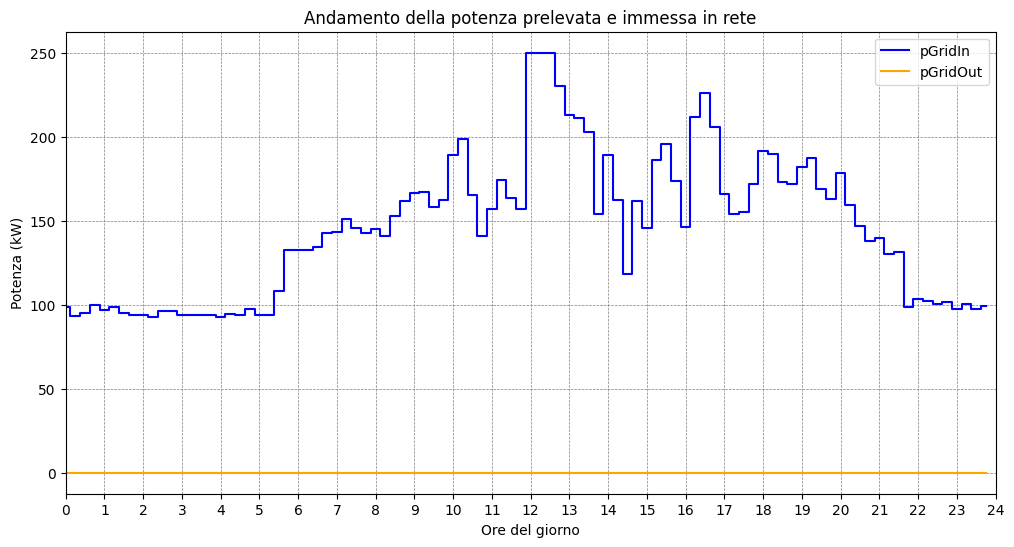

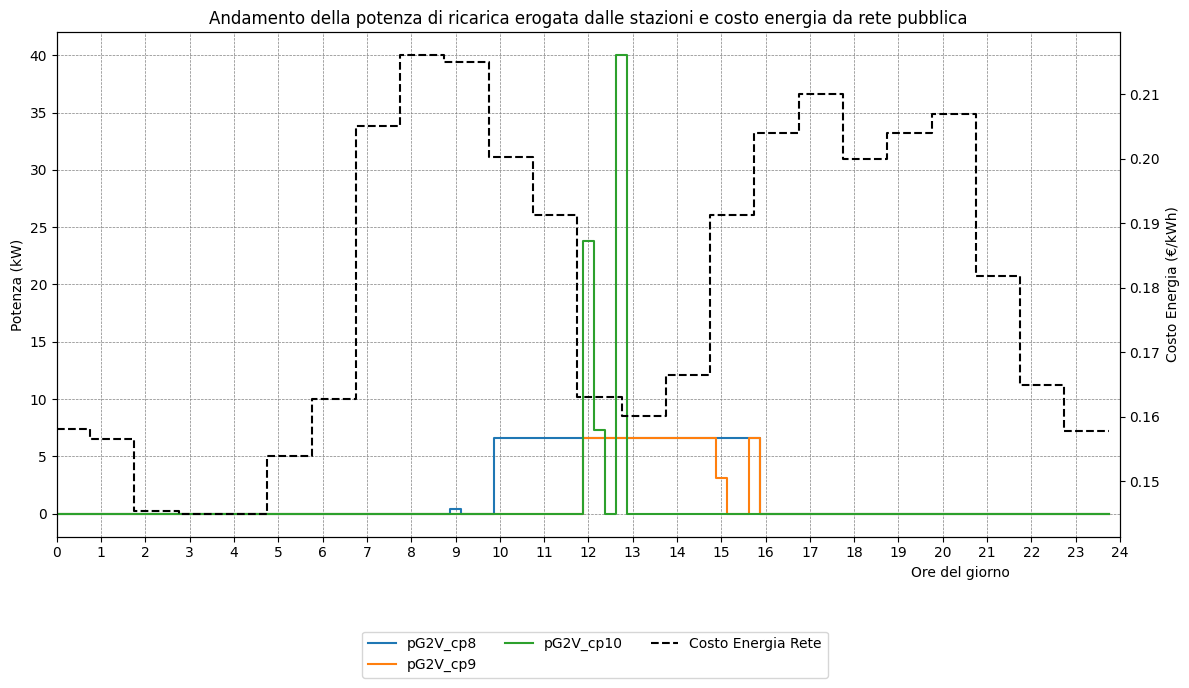

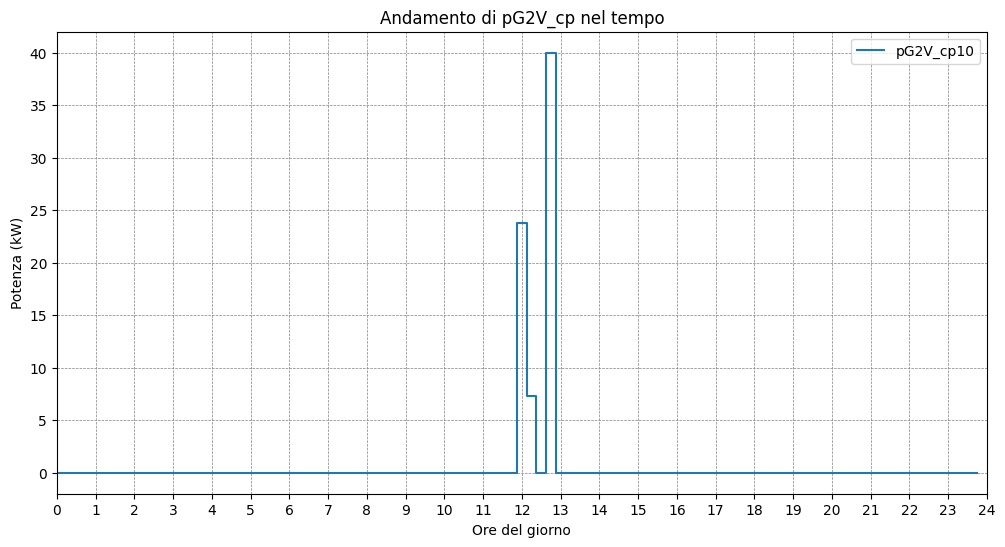

In [4]:
################# Visualizzazione risultati ##############################

hours_in_day = np.array([t * init_val['timestamp'] / 60 for t in range(nTimeStamp)])  # converti in ore

# Definisci i limiti e i ticks per l'asse orizzontale (da 0 a 24 ore)
x_ticks = np.arange(0, 25, 1)  # Tick ad ogni ora

# Grafico pGridIn e pGridOut con le ore sull'asse delle x
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, pGridIn_values, label="pGridIn", color='blue', where='mid')
plt.step(hours_in_day, pGridOut_values, label="pGridOut", color='orange', where='mid')
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza (kW)")
plt.title("Andamento della potenza prelevata e immessa in rete")
plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

# Grafico pG2V_cp con il costo dell'energia, usando le ore
fig, ax1 = plt.subplots(figsize=(12, 6))

# Grafico potenze G2V
for idx in [8,9,10]:
    ax1.step(hours_in_day, pG2V_cp_values[idx], label=f"pG2V_cp{idx}", where='mid')
ax1.set_xlabel("Ore del giorno", x=0.85)  # Sposta il titolo più a destra
ax1.set_ylabel("Potenza (kW)")
ax1.set_title("Andamento della potenza di ricarica erogata dalle stazioni e costo energia da rete pubblica")
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
ax1.set_xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
ax1.set_xticks(x_ticks)  # Mostra i ticks per ogni ora

# Crea il secondo asse per il costo dell'energia
ax2 = ax1.twinx()
ax2.step(hours_in_day, costi_in/timeStamp, label="Costo Energia Rete", linestyle="--", color='black')
ax2.set_ylabel("Costo Energia (€/kWh)")

# Posiziona la legenda in basso fuori dal grafico, ma in posizione centrale
fig.tight_layout()
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()

# Grafico pV2G_cp con le ore
# plt.figure(figsize=(12, 6))
# for idx in range(nWB):
#     plt.step(hours_in_day, pV2G_cp_values[idx], label=f"pV2G_cp{idx}", where='mid')
# plt.xlabel("Ore del giorno")
# plt.ylabel("Potenza (kW)")
# plt.title("Andamento della potenza di scarica dei veicoli connessi alle stazioni")
# plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
# plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
# plt.legend()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.show()

# Grafico SOC_cp (in percentuale rispetto alla capacità della batteria) con le ore
# plt.figure(figsize=(12, 6))
# for idx in range(nWB):
#     plt.step(hours_in_day, SOC_cp_percentage[idx], label=f"SOC_cp{idx}")
# plt.xlabel("Ore del giorno")
# plt.ylabel("Stato di Carica (%)")
# plt.title("Andamento SoC dei veicoli connessi alle stazioni di ricarica")
# plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
# plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
# plt.legend()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.show()

# # Grafico pG2V di una stazione scelta
n=10  #numero colonnina da stampare (da 0 a 11)

plt.figure(figsize=(12, 6))
plt.step(hours_in_day, pG2V_cp_values[n], label=f"pG2V_cp{n}", where='mid')
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza (kW)")
plt.title("Andamento di pG2V_cp nel tempo")
plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

# # Grafico SOC_cp di una stazione scelta (esempio CP_0)
# plt.figure(figsize=(12, 6))
# plt.plot(hours_in_day, SOC_cp_percentage[0], label=f"SOC_cp{0}")
# plt.xlabel("Ore del giorno")
# plt.ylabel("Stato di Carica (%)")
# plt.title("Andamento di SOC_cp (in %) nel tempo per ogni stazione di ricarica")
# plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
# plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
# plt.legend()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.show()

# Grafico pG2V_cp e andamento SoC per una stazione scelta (per esempio CP_0)
#fig, ax1 = plt.subplots(figsize=(12, 6))

# Grafico potenze G2V
# ax1.step(hours_in_day, pG2V_cp_values[2], label=f"pG2V_cp{2}", where='mid')
# ax1.set_xlabel("Ore del giorno")
# ax1.set_ylabel("Potenza (kW)")
# ax1.set_title(f"Andamento della potenza di ricarica e dello stato di carica ai veicoli connessi alla stazione {0}")
# ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
# ax1.set_xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
# ax1.set_xticks(x_ticks)  # Mostra i ticks per ogni ora

# # Crea il secondo asse per il SOC
# ax2 = ax1.twinx()
# ax2.plot(hours_in_day, SOC_cp_percentage[2], label=f"SOC_cp{2}", color='red')
# ax2.set_ylabel("SoC di carica (%)")

# # Aggiungi la leggenda per entrambe le serie di dati
# lines_labels_1 = ax1.get_legend_handles_labels()
# lines_labels_2 = ax2.get_legend_handles_labels()

# # Combina le etichette
# lines = lines_labels_1[0] + lines_labels_2[0]
# labels = lines_labels_1[1] + lines_labels_2[1]

# # Posiziona la legenda fuori dal grafico e su più colonne
# ax1.legend(lines, labels)

# plt.show()